In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow

In [3]:
!nvidia-smi

Thu Apr 21 13:37:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import

In [5]:
import os
import sys
import csv
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Фиксируем окружение

In [6]:
!pip freeze > requirements.txt

# Основные настройки

In [91]:
EPOCHS               = 12    # эпох на обучение
BATCH_SIZE           = 9   # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4 # скорость обучения
VAL_SPLIT            = 0.2  # 20% данных выделяем на тест
# ACTIVATION           = 'sigmoid' # функция активации
# ACTIVATION           = 'tanh' # функция активации
# ACTIVATION           = 'relu' # функция активации
ACTIVATION           = L.LeakyReLU(0.2) # функция активации


CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = 256  # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3    # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# for augmentation
WIDTH_SHIFT_RANGE    = 0.15
HEIGHT_SHIFT_RANGE   = 0.15
HORIZONTAL_FLIP      = True
VERTICAL_FLIP        = False
ROTATION_RANGE       = 15
BRIGHTNES_RANGE      = (0.5, 1.5)
SHEAR_RANGE          = 0.2
ZOOM_RANGE           = 0.15

# Colab
DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/project_7/input')
SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/project_7')
PATH = os.path.join(os.getcwd(), 'working', 'car') # рабочая директория

# Kaggle
# DATA_PATH = os.path.abspath('../input/car-classification')
# WORK_PATH = os.path.abspath('./') # рабочая директория

In [14]:
# создаём рабочую директорию
os.makedirs(PATH, exist_ok=True)    # для Kaggle - закомментировать

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 12
# np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Версии

In [15]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Mar 16 2022, 17:37:17) 
Numpy        : 1.21.6
Tensorflow   : 2.8.0
Keras        : 2.8.0


In [ ]:
def get_model(base_model):
    model=M.Sequential()
    model.add(base_model)

    # model layer 1
    model.add(L.Convolution2D(128, (3, 3), input_shape=INPUT_SHAPE, activation=ACTIVATION, padding='same',))
    model.add(L.BatchNormalization())
    # model.add(L.Activation(ACTIVATION))

    # Pooling layer 1
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))

    # model layer 2
    model.add(L.Convolution2D(256, (3, 3), activation=ACTIVATION, padding='same',))
    model.add(L.BatchNormalization())
    # model.add(L.Activation(ACTIVATION))

    # Pooling layer 2
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.25))

    # model layer 3.
    model.add(L.Convolution2D(512, (3, 3), activation=ACTIVATION, padding='same',))
    model.add(L.BatchNormalization())
    # model.add(L.Activation(ACTIVATION))

    # Pooling layer 3
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))

    # Flattening
    model.add(L.Flatten())

    # Full connection
    # model.add(L.Dense(1024, activation=ACTIVATION))
    model.add(L.Dense(512, activation=ACTIVATION))
    model.add(L.Dense(256, activation=ACTIVATION))
    # model.add(L.Dense(128, activation=ACTIVATION))
    # model.add(L.Dense(64, activation=ACTIVATION))
    # model.add(L.Dense(32, activation=ACTIVATION))
    model.add(L.Dropout(0.3))
    model.add(L.Dense(CLASS_NUM, activation='softmax'))

    #--------------------------OR--------------------------#

    # model = M.Sequential()
    # model.add(base_model)
    # model.add(L.GlobalAveragePooling2D())
    # model.add(L.Dense(256, activation='relu'))
    # model.add(L.BatchNormalization())
    # model.add(L.Dropout(0.25))
    # model.add(L.Dense(CLASS_NUM, activation='softmax'))

    return model

def fit_model(model):
    return model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
    )


In [24]:
# Colab
def veiw_random_images(random_image_paths, random_image_cat):
    for index, path in enumerate(random_image_paths):
        im = PIL.Image.open(os.path.join(PATH, 'train', str(random_image_cat[index]), str(path)))
        plt.subplot(3,3, index+1)
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(im)
        plt.title('Class: ' + str(random_image_cat[index]))
    plt.show()

# # Kaggle
# def veiw_random_images(random_image_paths, random_image_cat):
#     for index, path in enumerate(random_image_paths):
#         im = PIL.Image.open(os.path.join(DATA_PATH, 'train', 'train', str(random_image_cat[index]), str(path)))
#         plt.subplot(3,3, index+1)
#         plt.subplots_adjust(hspace=0.5)
#         plt.imshow(im)
#         plt.title('Class: ' + str(random_image_cat[index]))
#     plt.show()

In [140]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# EDA / Анализ данных

In [16]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample-submission.csv'))

In [17]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [19]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

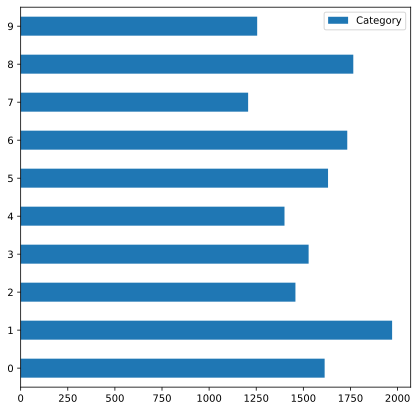

In [20]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='barh', figsize=(7, 7))

Распределение классов достаточно равномерное.

In [21]:
# для Kaggle закомментировать
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(os.path.join(DATA_PATH, data_zip),"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжать.

Пример картинок


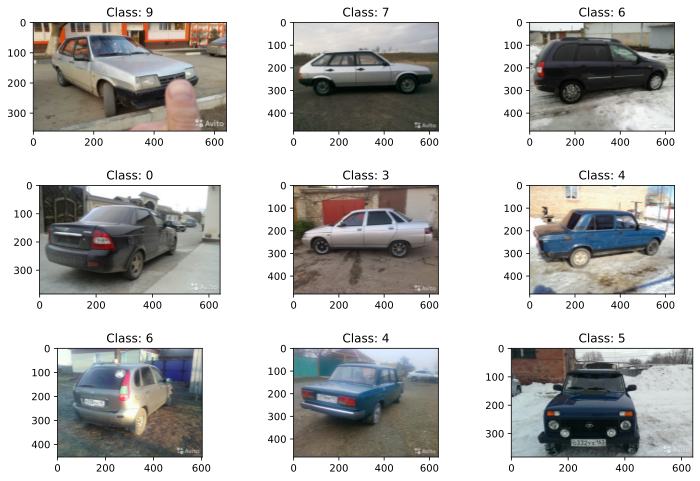

In [25]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Изображения вполне различимы. Имеют разный размер.

Посмотрим на изображения одного класса.

Пример картинок одного класса


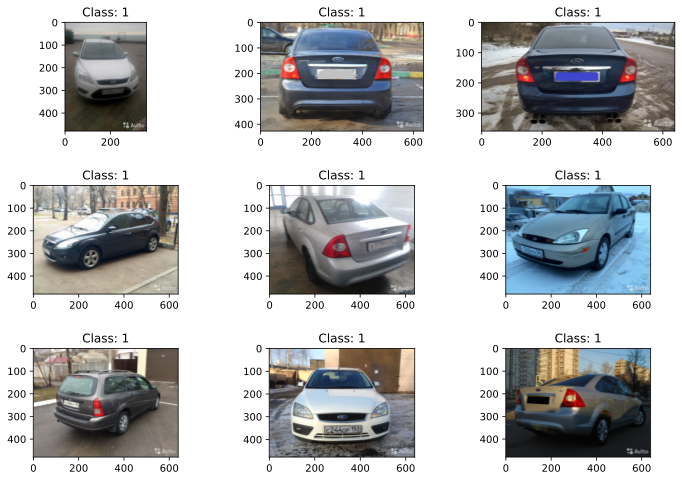

In [26]:
print('Пример картинок одного класса')
plt.figure(figsize=(12,8))

random_image = train_df.loc[train_df['Category'] == 1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Очевидно что класс это модель автомобиля. 

# Подготовка данных

### Аугментация данных

Т.к. данных относительно не много, следует прибегнуть к аугментации данных.  
Чтобы экономить ресурсы железа создадим генератор, который будет подавать в модель изображения порциями.  
За аугментацию так же будет отвечать генератор.  

In [126]:
# из-за этого генератора всё ломается
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = ROTATION_RANGE,
#     brightness_range=BRIGHTNES_RANGE,
#     shear_range=SHEAR_RANGE,
#     zoom_range=ZOOM_RANGE,
#     width_shift_range=WIDTH_SHIFT_RANGE,
#     height_shift_range=HEIGHT_SHIFT_RANGE,
#     validation_split=VAL_SPLIT,
#     horizontal_flip=HORIZONTAL_FLIP,
#     vertical_flip=VERTICAL_FLIP
#     )

# test_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     validation_split=VAL_SPLIT
#     )


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = ROTATION_RANGE,
    brightness_range=BRIGHTNES_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    validation_split=VAL_SPLIT,
    horizontal_flip=HORIZONTAL_FLIP
    )


# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.1,
#     zoom_range=0.1,
#     validation_split=VAL_SPLIT,
#     horizontal_flip=True
#     )

test_datagen = ImageDataGenerator(rescale=1. / 255)



#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [127]:
# Завернем наши данные в генератор:
# Colab
train_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    os.path.join(PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=os.path.join(PATH, 'test_upload'),
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# # Kaggle
# train_generator = train_datagen.flow_from_directory(
#     os.path.join(DATA_PATH, 'train', 'train'),
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True, 
#     seed=RANDOM_SEED,
#     subset='training') # set as training data

# test_generator = train_datagen.flow_from_directory(
#     os.path.join(DATA_PATH, 'train', 'train'),
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True, 
#     seed=RANDOM_SEED,
#     subset='validation') # set as validation data

# test_sub_generator = test_datagen.flow_from_dataframe( 
#     dataframe=sample_submission,
#     directory=os.path.join(DATA_PATH, 'test', 'test_upload'),
#     x_col="Id",
#     y_col=None,
#     shuffle=False,
#     class_mode=None,
#     seed=RANDOM_SEED,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Данные разбиты корректно: в каждой группе равное количество классов.

# Посмотрим аугментацию данных.

Пример аугментированных картинок из train_generator


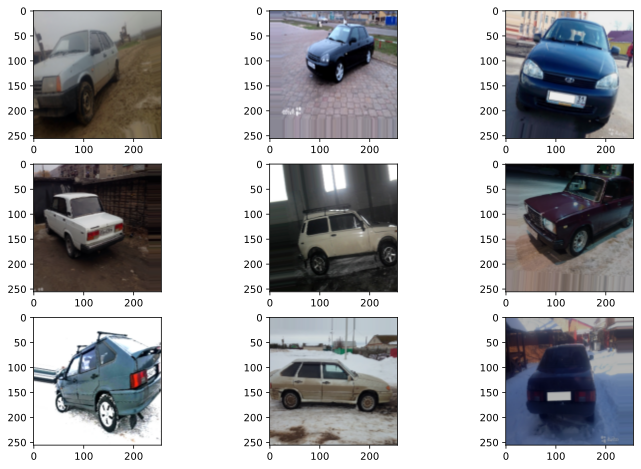

In [128]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример аугментированных картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [129]:
# raise KeyboardInterrupt

# Построение модели

### Сеть Xception

In [130]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)

In [131]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [132]:
# raise KeyboardInterrupt

In [133]:
base_model.trainable = False
XC_model = get_model(base_model)

In [136]:
XC_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         2359424   
                                                                 
 batch_normalization_41 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 4, 4, 128)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 4, 4, 256)        

In [137]:
# сколько слоев
print(len(XC_model.layers))

18


Проверим что подгруженная сеть не будет обучаться.

In [138]:
for layer in XC_model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fd4f1fa43d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd4e07a1550> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd4e0061e90> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd4e004da90> True
<keras.layers.core.dropout.Dropout object at 0x7fd40013be10> True
<keras.layers.convolutional.Conv2D object at 0x7fd40013bd10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd40013bf90> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd40011d250> True
<keras.layers.core.dropout.Dropout object at 0x7fd3f9ea2ad0> True
<keras.layers.convolutional.Conv2D object at 0x7fd3fdd73790> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd3fdd73290> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3fdd608d0> True
<keras.layers.core.dropout.Dropout object at 0x7fd3fdd607d0> True
<keras.layers.core.flatten.Flatten object at

### Обучаем.

In [139]:
LR=0.001
XC_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [141]:
cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 'best_model.hdf5') , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
cb_earlystop = EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

In [142]:
history = fit_model(XC_model)

Epoch 1/12
1384/1384 [==============================] - ETA: 0s - loss: 1.7958 - accuracy: 0.3714
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 420s 295ms/step - loss: 1.7958 - accuracy: 0.3714 - val_loss: 1.3455 - val_accuracy: 0.5098 - lr: 0.0010
Epoch 2/12
1384/1384 [==============================] - ETA: 0s - loss: 1.4360 - accuracy: 0.4860
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 458s 331ms/step - loss: 1.4360 - accuracy: 0.4860 - val_loss: 1.3841 - val_accuracy: 0.5130 - lr: 0.0010
Epoch 3/12
1384/1384 [==============================] - ETA: 0s - loss: 1.2795 - accuracy: 0.5441
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 459s 331ms/step - loss: 1.2795 - accuracy: 0.5441 - val_loss: 1.2362 - val_accuracy: 0.5619

In [143]:
# for _ in range(EPOCHS):
  # history = model.fit(
  #     train_generator,
  #     steps_per_epoch = train_generator.samples//train_generator.batch_size,
  #     validation_data = test_generator, 
  #     validation_steps = test_generator.samples//test_generator.batch_size,
  #     epochs = 1,
  #     callbacks = callbacks_list
  #     )
  # model.save(os.path.join(SAVE_PATH, 'model_step1.hdf5'))
  # model.load_weights(os.path.join(SAVE_PATH, 'best_model.hdf5'))


In [144]:
# сохраним итоговую сеть
# Colab
XC_model.save(os.path.join(SAVE_PATH, 'XC_model_step1.hdf5'))

# Kaggle
# XC_model.save(os.path.join(WORK_PATH, 'XC_model_step1.hdf5'))

In [145]:
# подгрузим лучшую итерацию в обучении (best_model)
# Colab
XC_model.load_weights(os.path.join(SAVE_PATH, 'best_XC_model.hdf5'))

# Kaggle
# XC_model.load_weights(os.path.join(WORK_PATH, 'best_XC_model.hdf5'))

In [146]:
scores = XC_model.evaluate_generator(test_generator, 
                                  steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


346/346 [==============================] - 86s 249ms/step - loss: 0.7902 - accuracy: 0.7160
Accuracy: 71.60%


Посмотрим график обучения.

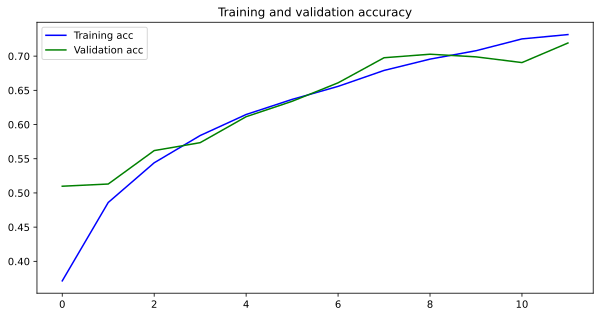

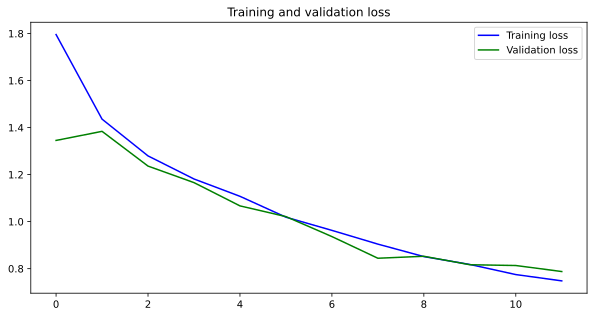

In [147]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    #plt.style.use('dark_background')
    plt.legend()

    plt.show()

plot_history(history)

In [148]:
# raise KeyboardInterrupt

### Этап второй.

In [149]:
# Раскомментировать при обрыве обучения
# Colab
# XC_model.load_weights(os.path.join(SAVE_PATH, 'best_XC_model.hdf5'))


# Kaggle
# XC_model.load_weights(os.path.join(WORK_PATH, 'best_XC_model.hdf5'))

Разморозим половину слоёв.

In [150]:
base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Посмотрим сколько слоёв будет обучаться.

In [151]:
len(base_model.trainable_variables)

79

Проверяем что подгруженная сеть тоже включается в обучение.

In [152]:
# Check the trainable status of the individual layers
for layer in XC_model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fd4f1fa43d0> True
<keras.layers.convolutional.Conv2D object at 0x7fd4e07a1550> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd4e0061e90> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd4e004da90> True
<keras.layers.core.dropout.Dropout object at 0x7fd40013be10> True
<keras.layers.convolutional.Conv2D object at 0x7fd40013bd10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd40013bf90> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd40011d250> True
<keras.layers.core.dropout.Dropout object at 0x7fd3f9ea2ad0> True
<keras.layers.convolutional.Conv2D object at 0x7fd3fdd73790> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd3fdd73290> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd3fdd608d0> True
<keras.layers.core.dropout.Dropout object at 0x7fd3fdd607d0> True
<keras.layers.core.flatten.Flatten object at 

Обучаем.

In [153]:
LR=0.0001
XC_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [154]:
XC_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 128)         2359424   
                                                                 
 batch_normalization_41 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 4, 4, 128)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 4, 4, 256)        

In [ ]:
history = fit_model(XC_model)

Epoch 1/12
1384/1384 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7437
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 497s 355ms/step - loss: 0.7324 - accuracy: 0.7437 - val_loss: 0.4388 - val_accuracy: 0.8376 - lr: 1.0000e-04
Epoch 2/12
1384/1384 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8592
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 500s 361ms/step - loss: 0.3985 - accuracy: 0.8592 - val_loss: 0.3076 - val_accuracy: 0.8926 - lr: 1.0000e-04
Epoch 3/12
1384/1384 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8955
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/best_model.hdf5
1384/1384 [==============================] - 503s 363ms/step - loss: 0.2918 - accuracy: 0.8955 - val_loss: 0.2922 - val_accuracy

In [ ]:
# Colab
XC_model.save(os.path.join(SAVE_PATH, 'model_step2.hdf5'))

# Kaggle
# XC_model.save(os.path.join(WORK_PATH, 'model_step2.hdf5'))

In [ ]:
# Colab
XC_model.load_weights(os.path.join(SAVE_PATH, 'best_model.hdf5'))

# Kaggle
# XC_model.load_weights(os.path.join(WORK_PATH, 'best_model.hdf5'))

In [ ]:
scores = XC_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

In [ ]:
# raise KeyboardInterrupt

### Этап третий.
Обучаем все слои.

In [ ]:
# # Раскомментировать при обрыве обучения
# model.load_weights(os.path.join(SAVE_PATH, 'best_model.hdf5'))

In [ ]:
base_model.trainable = True

In [ ]:
LR=0.00001
XC_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
history = fit_model(XC_model)

In [ ]:
# Colab
XC_model.save(os.path.join(SAVE_PATH, 'model_step3.hdf5'))

# Kaggle
# XC_model.save(os.path.join(WORK_PATH, 'model_step3.hdf5'))

In [ ]:
# Colab
XC_model.load_weights(os.path.join(SAVE_PATH, 'best_model.hdf5'))

# Kaggle
# XC_model.load_weights(os.path.join(WORK_PATH, 'best_model.hdf5'))

In [ ]:
scores = XC_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

In [ ]:
raise KeyboardInterrupt

### Сеть EfficientNetB6

In [ ]:
base_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [ ]:
base_model.trainable = False
ENB6_model = get_model(base_model)

In [ ]:
raise KeyboardInterrupt

### Сеть EfficientNetB7

In [ ]:
base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
ENB7_model = get_model(base_model)

### Сеть EfficientNetV2M

In [ ]:
base_model = tf.keras.applications.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
ENBV2_model = get_model(base_model)

В Итоге точность нашей модели составила XX%.   
Учитывая что классов 10 - это Очень хороший результат!     

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [ ]:
submission.head()

* Настройте LR, optimizer, loss
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!